In [1]:
import sys

import numpy as np
import xscen as xs
import cartopy.crs as ccrs
from xscen.config import CONFIG
import figanos.matplotlib as fg

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


fg.utils.set_mpl_style('ouranos')

# Load configuration
xs.load_config(
    "../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True
)

In [2]:
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

Processing variable: pr_mean_seasonal_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
Processing variable: tg_mean_seasonal_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
	Horizon: 1991-2020
Processing variable: pr_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Detected annual data for pr_mean_annual_clim_mean — Horizon: 1981-2010
	Horizon: 1981-2010
Processing variable: pr_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
Processing variable: tg_mean_annual_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Detected annual data for tg_mean_annual_clim_std — Horizon: 1981-2010
	Horizon: 1981-2010
	Horizon: 1991-2020
Processing variable: tg_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
	Horizon: 1991-2020
Processing variable: pr_mean_annual_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Detected annual data for pr_mean_annual_clim_std — Horizon: 1981-2010
	Horizon: 1981-2010
Processing variable: tg_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Detected annual data for tg_mean_annual_clim_mean — Horizon: 1981-2010
	Horizon: 1981-2010
	Horizon: 1991-2020


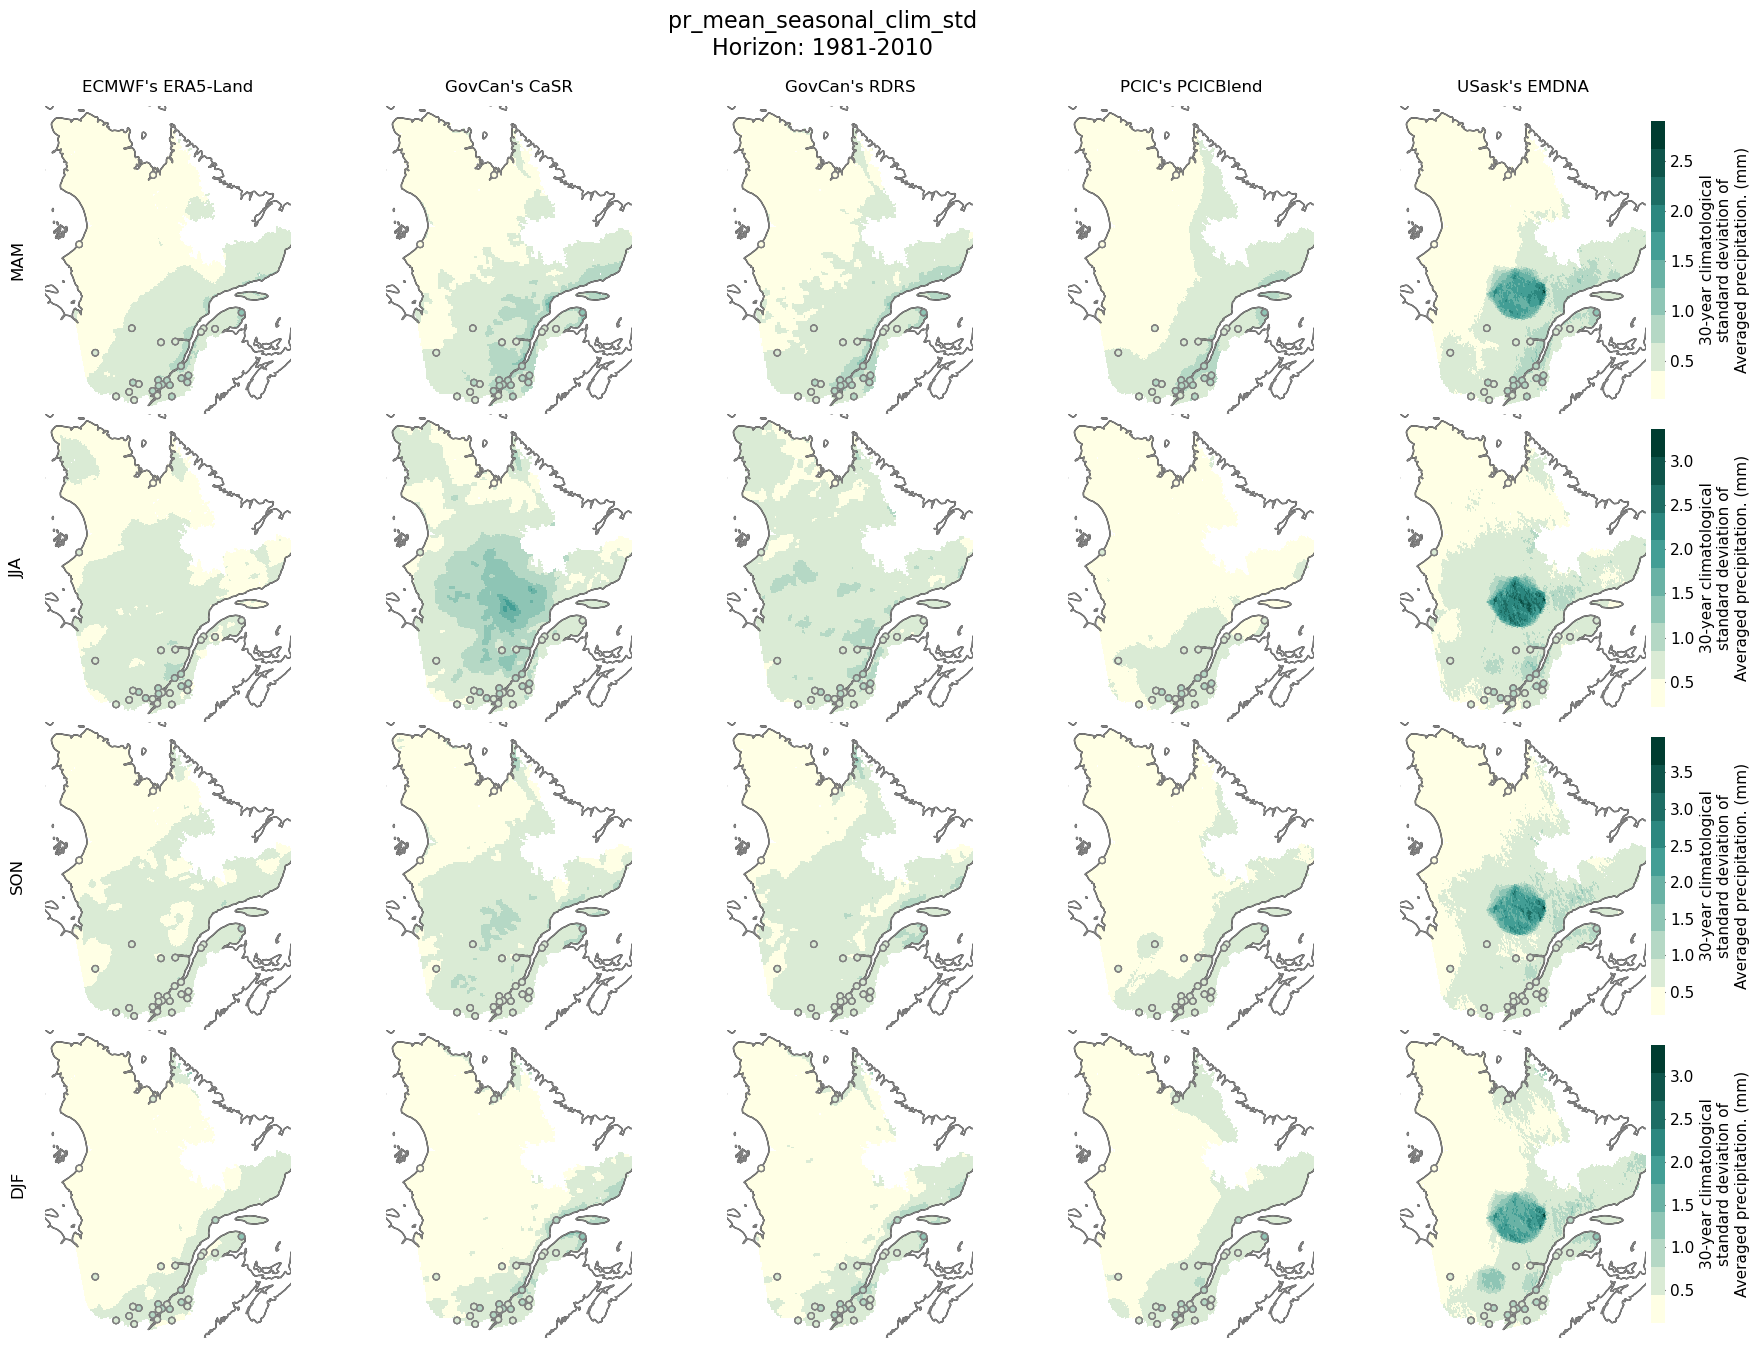

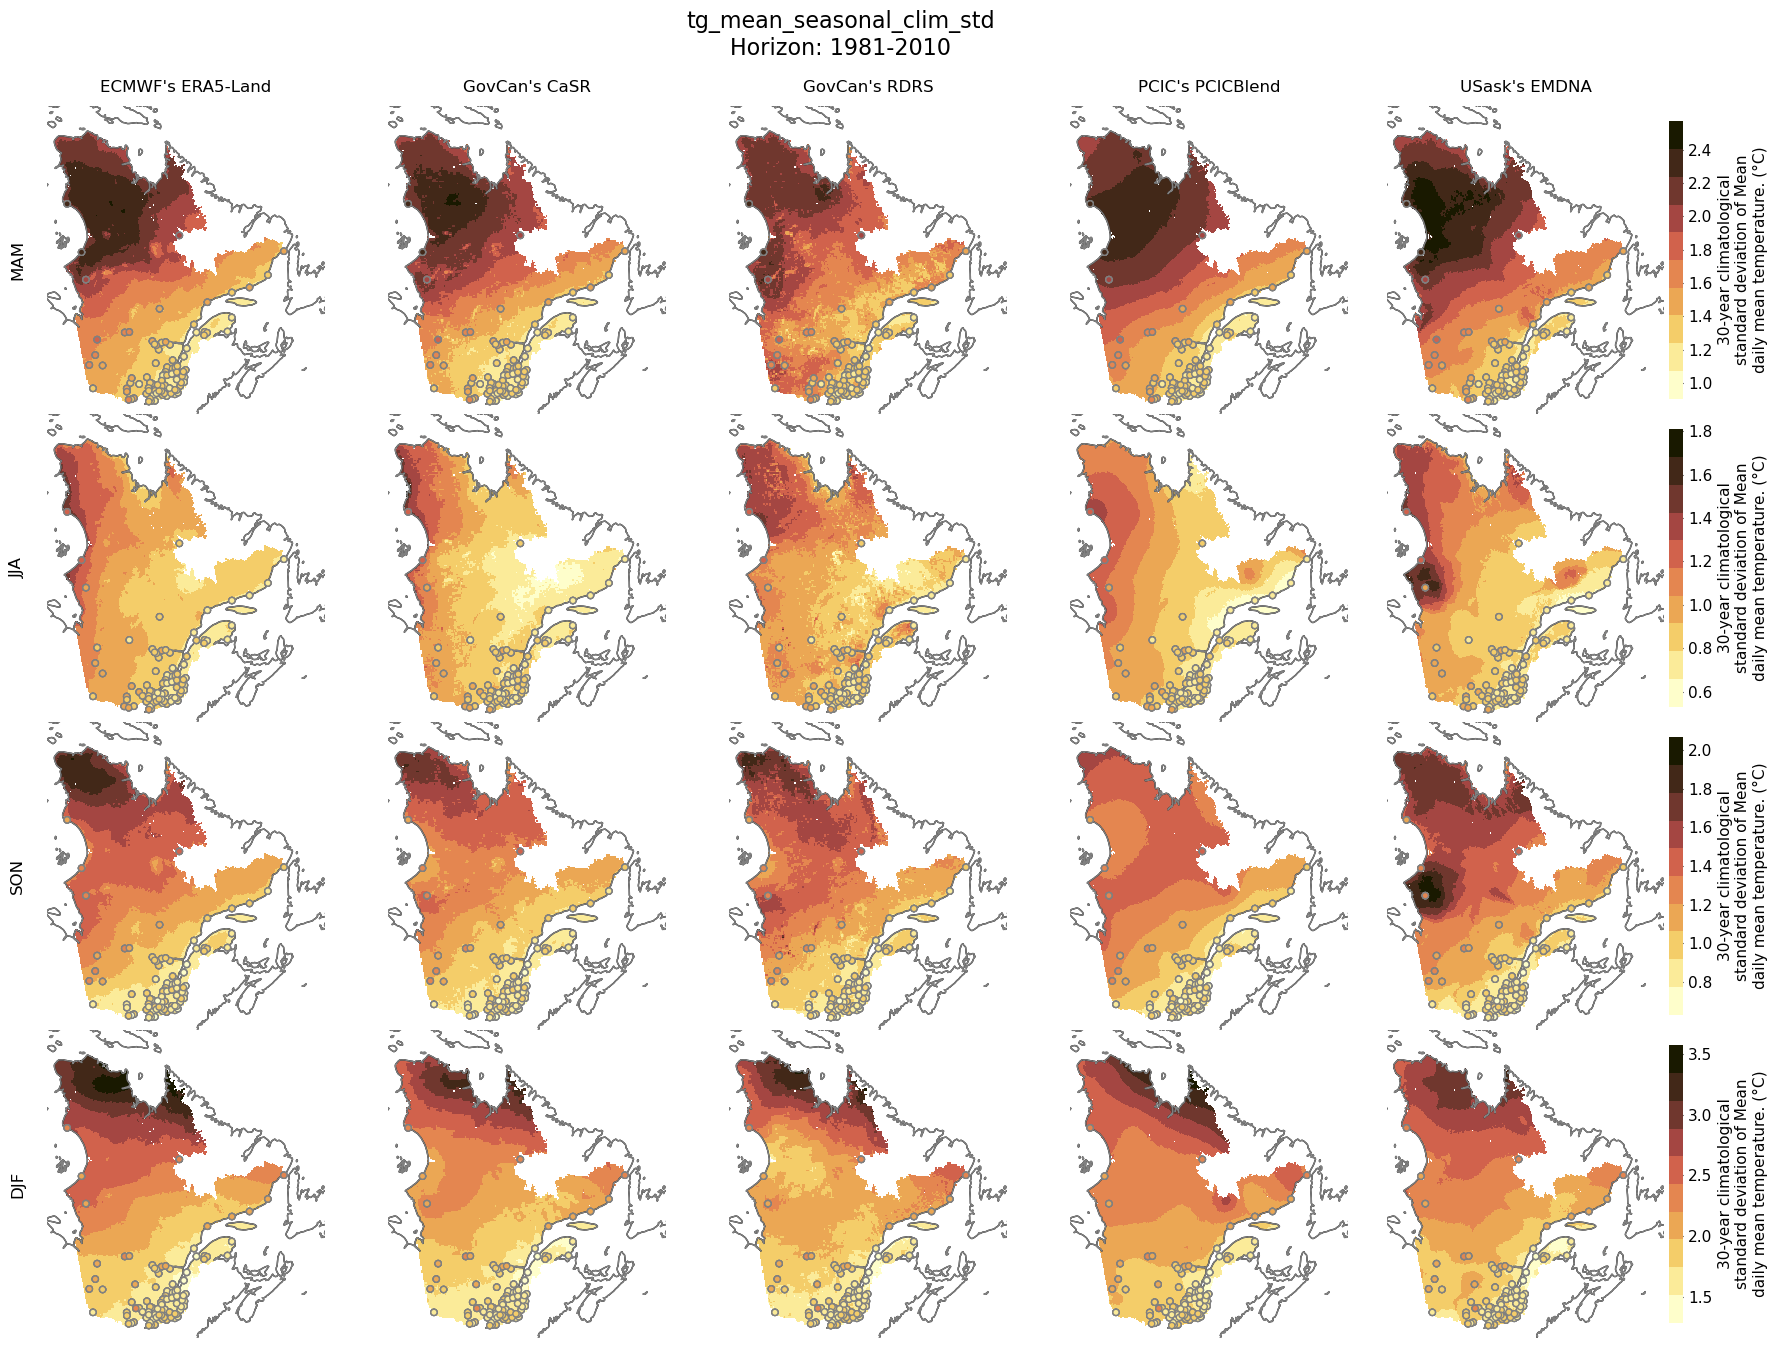

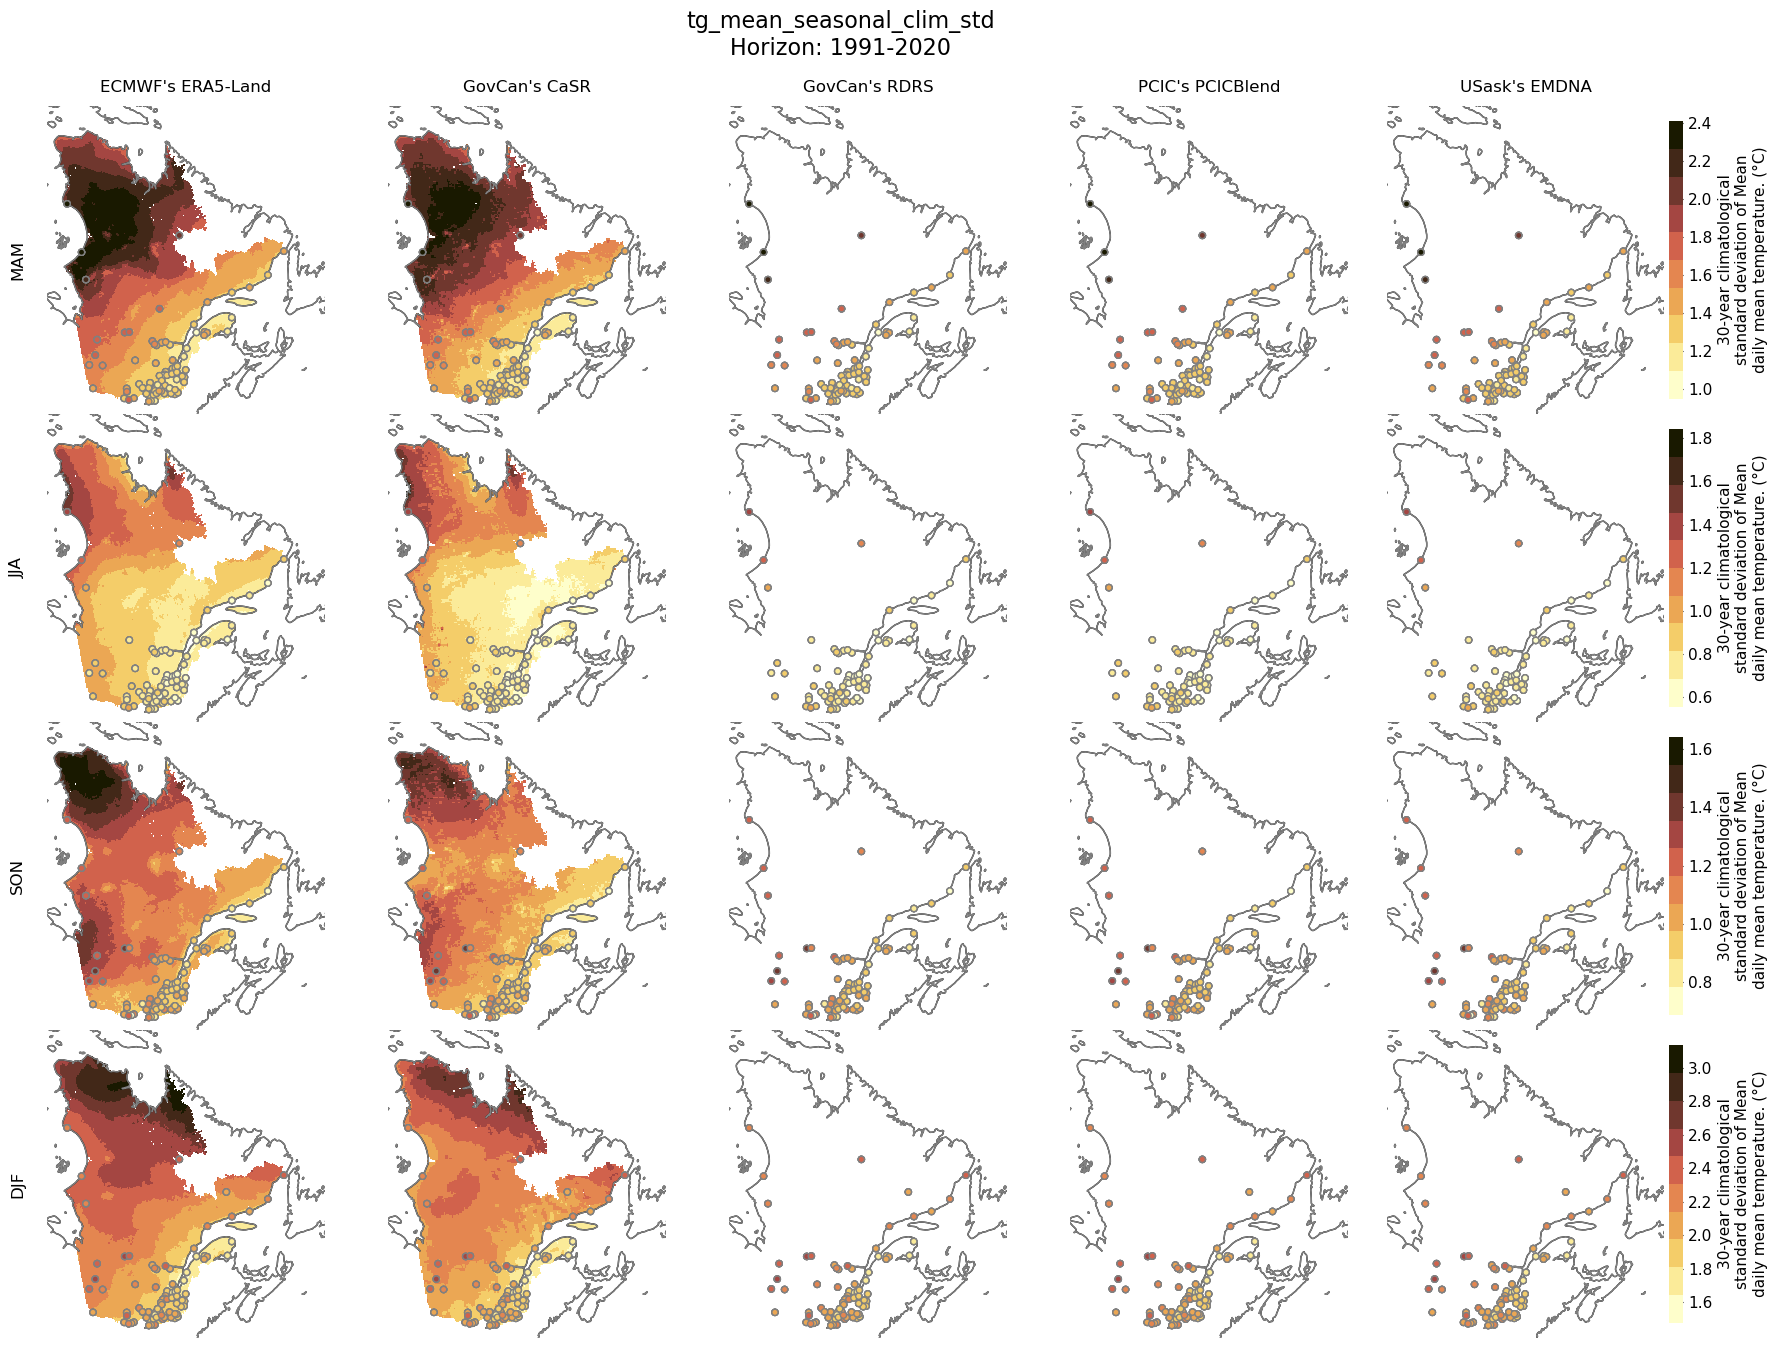

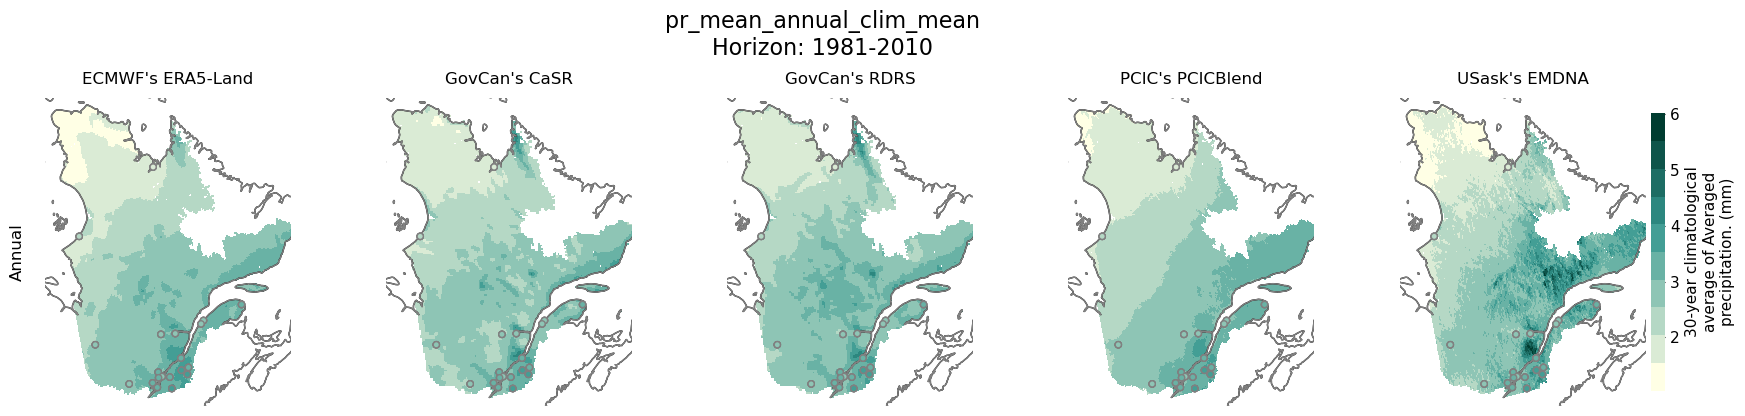

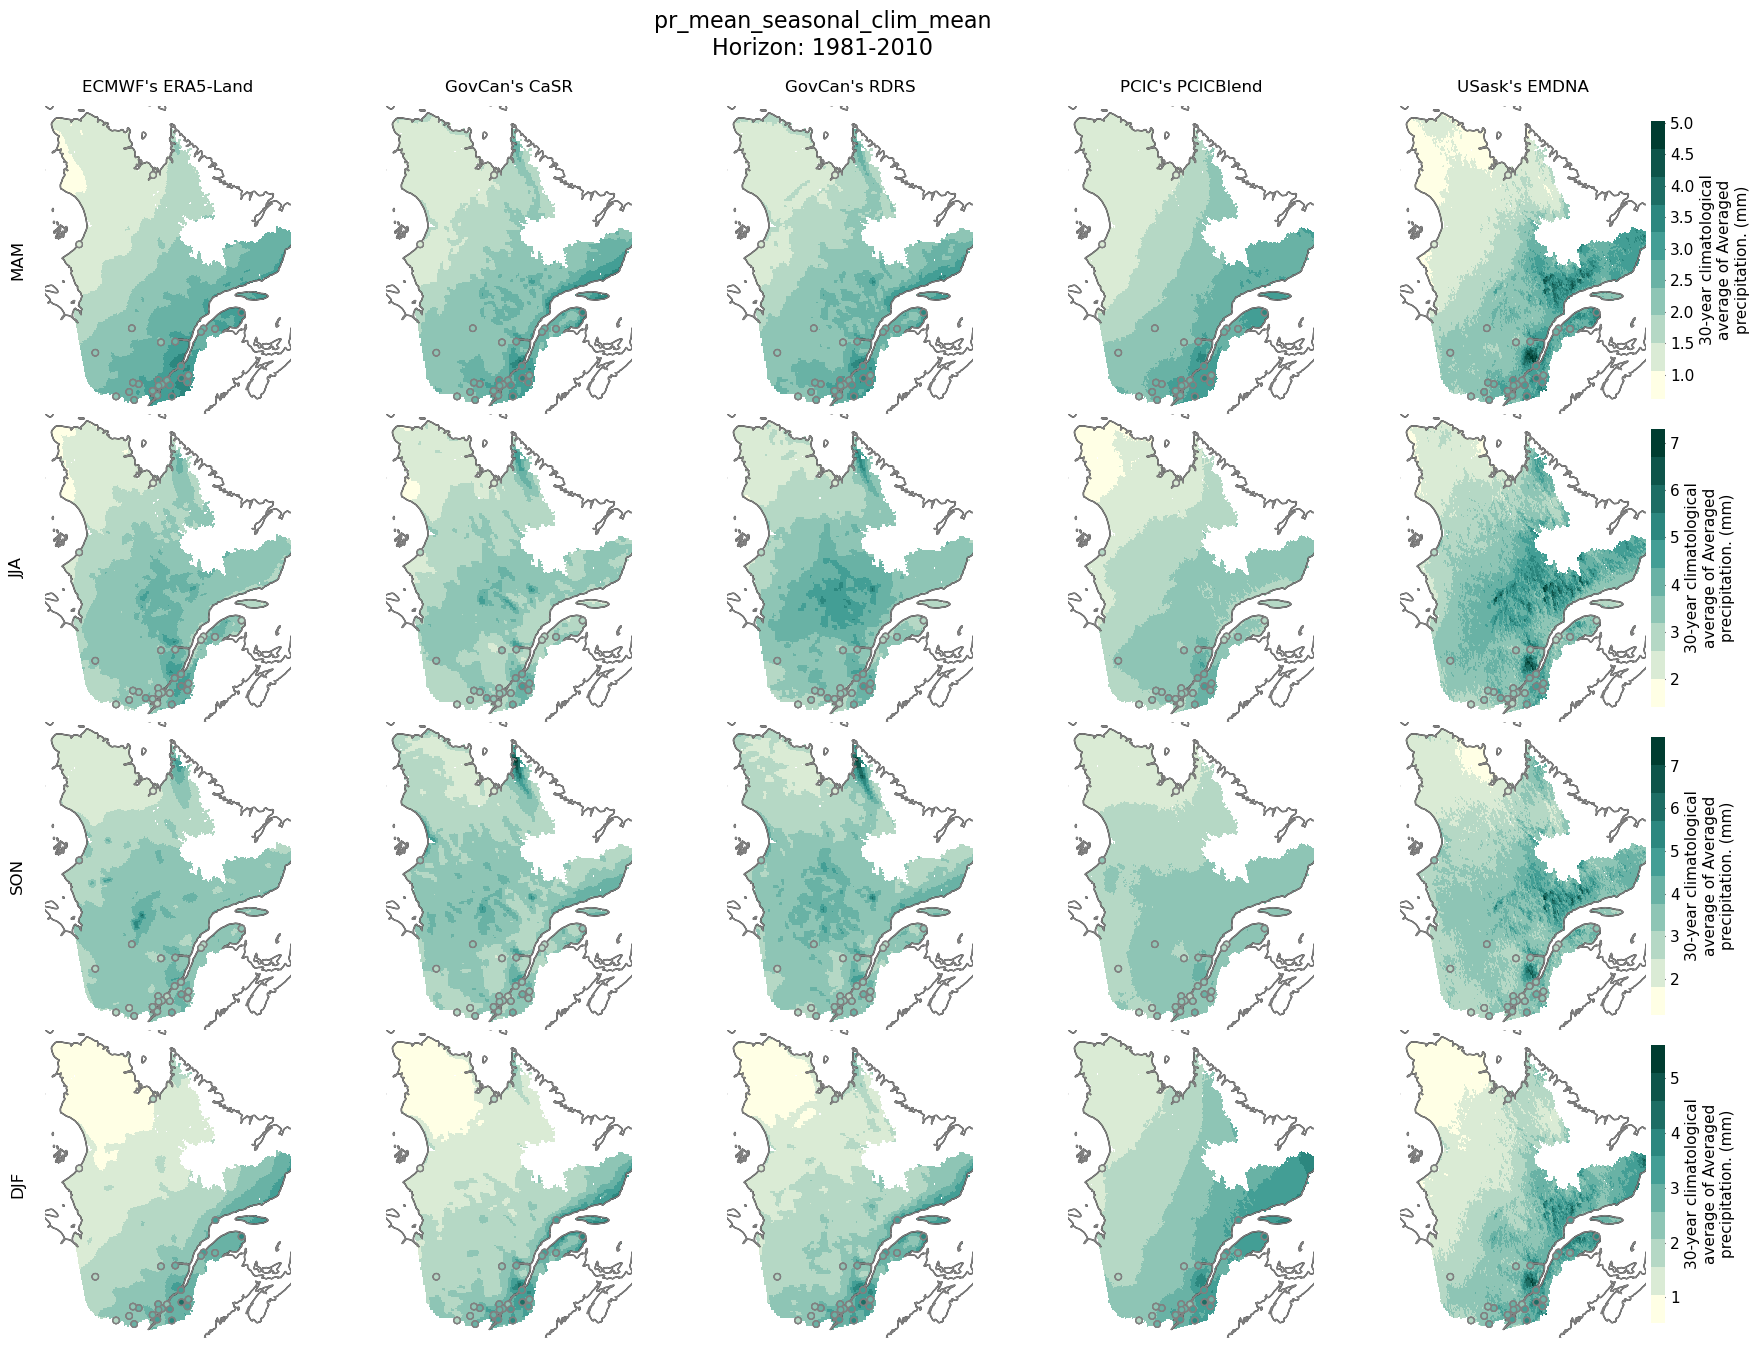

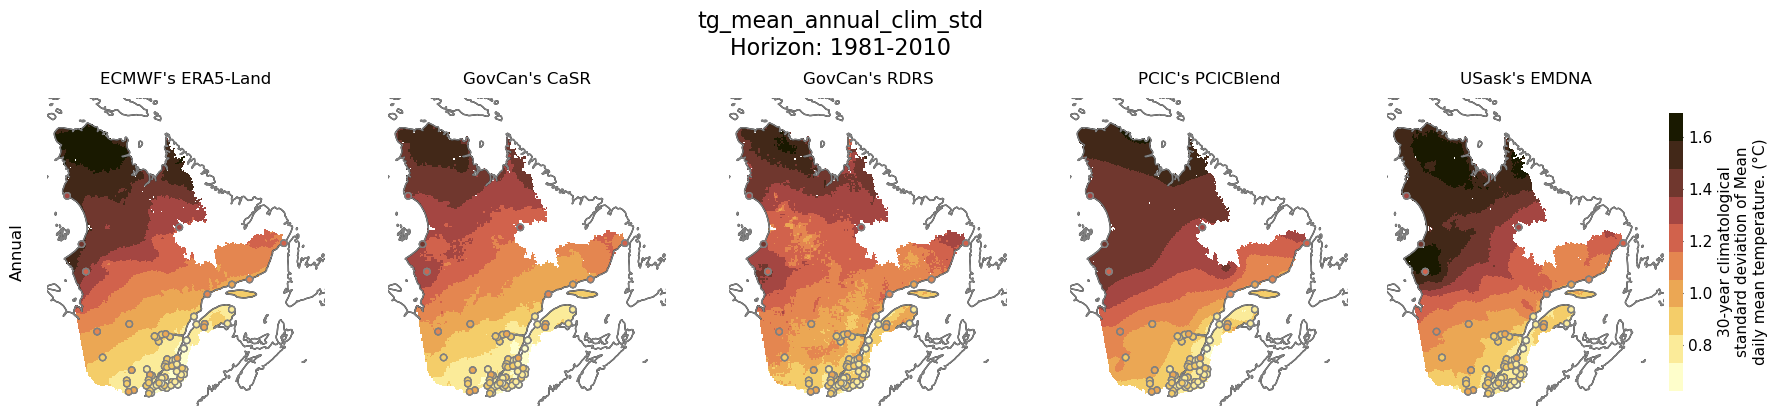

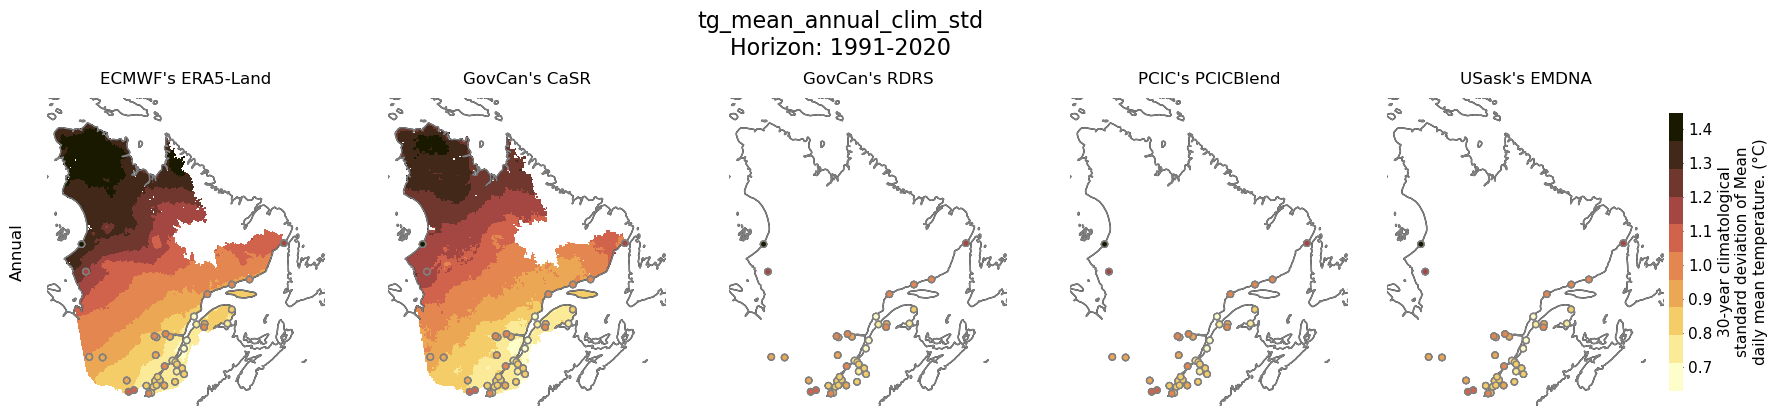

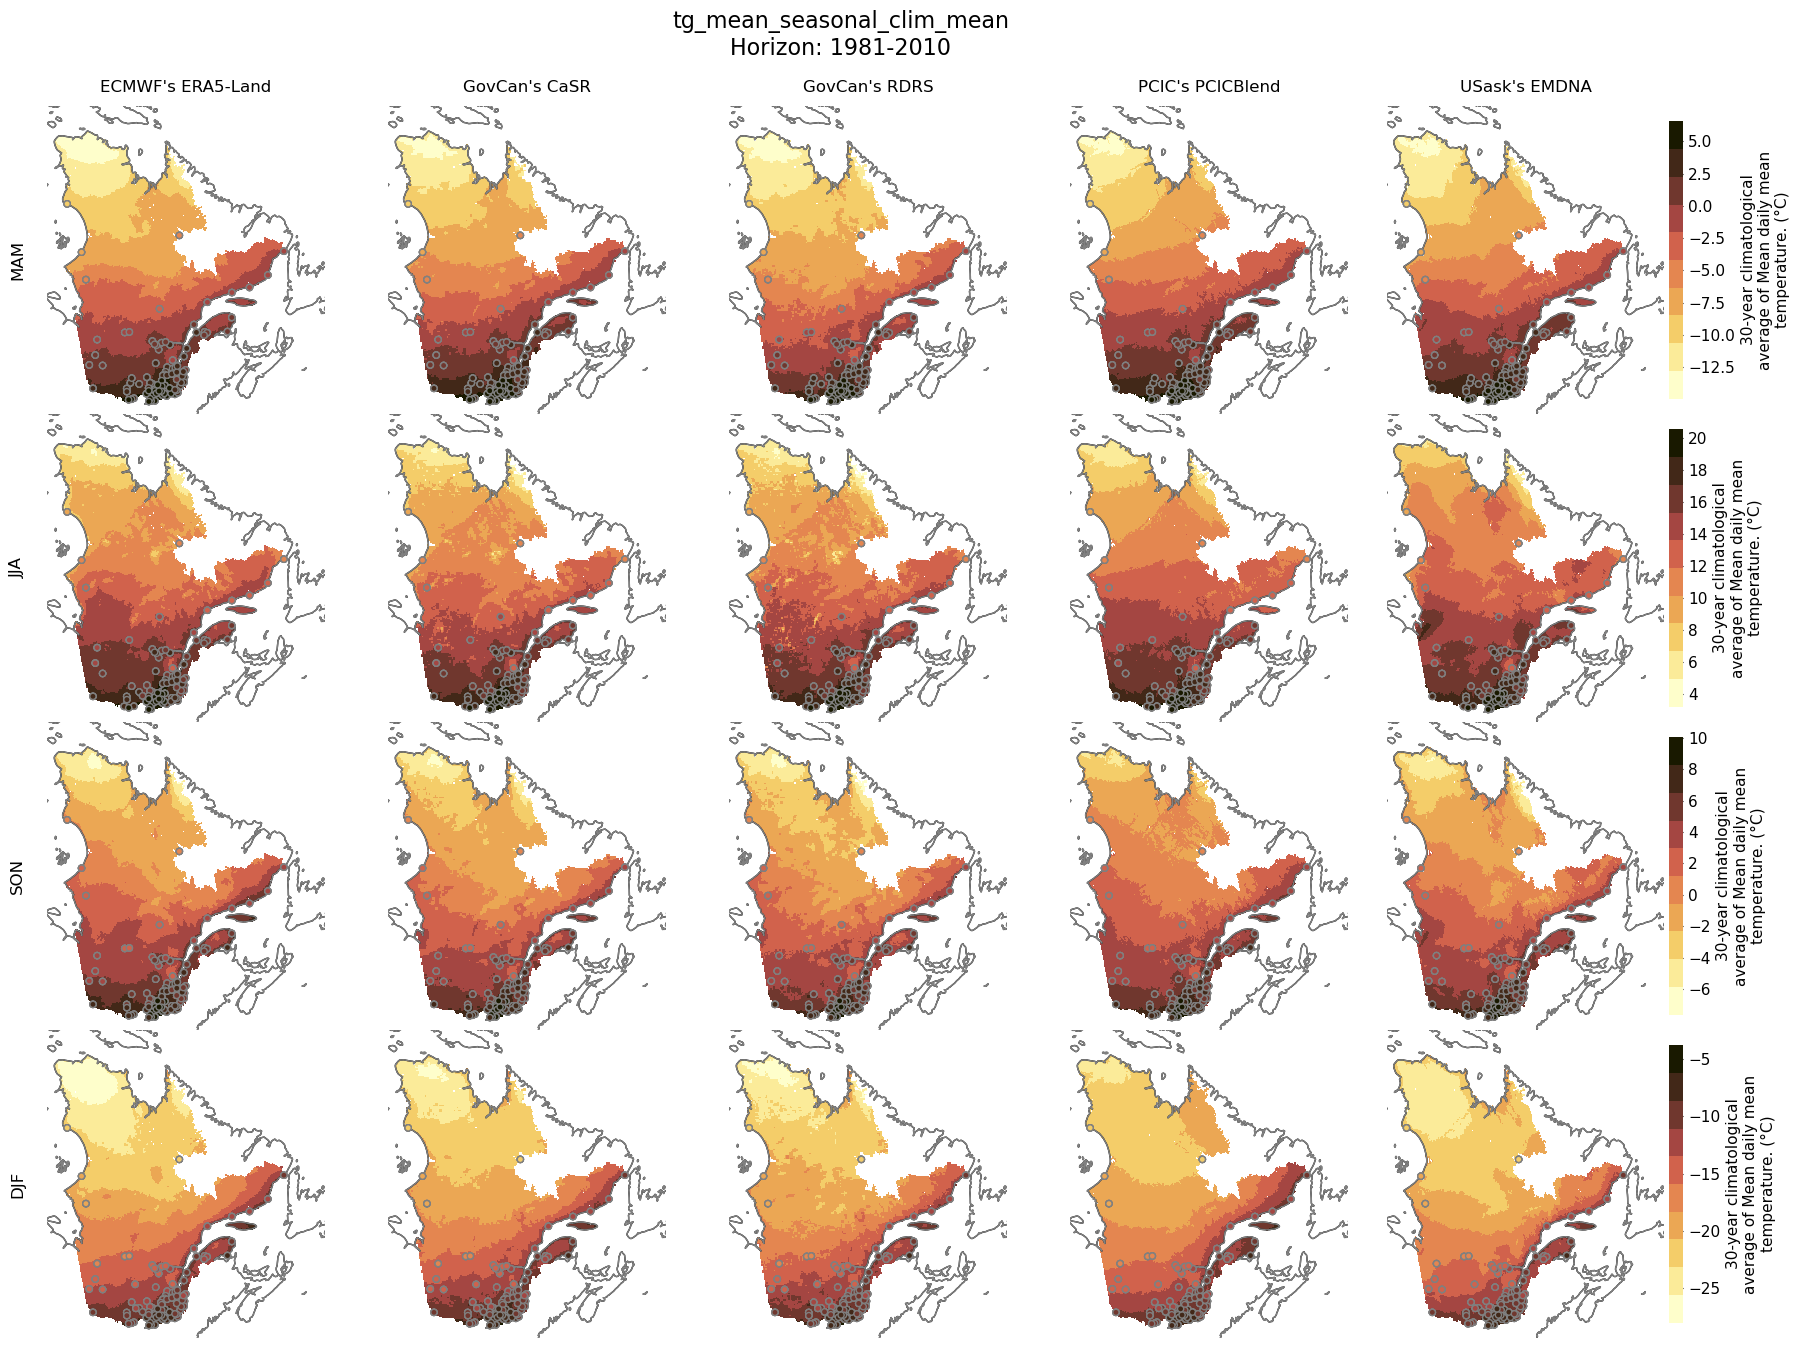

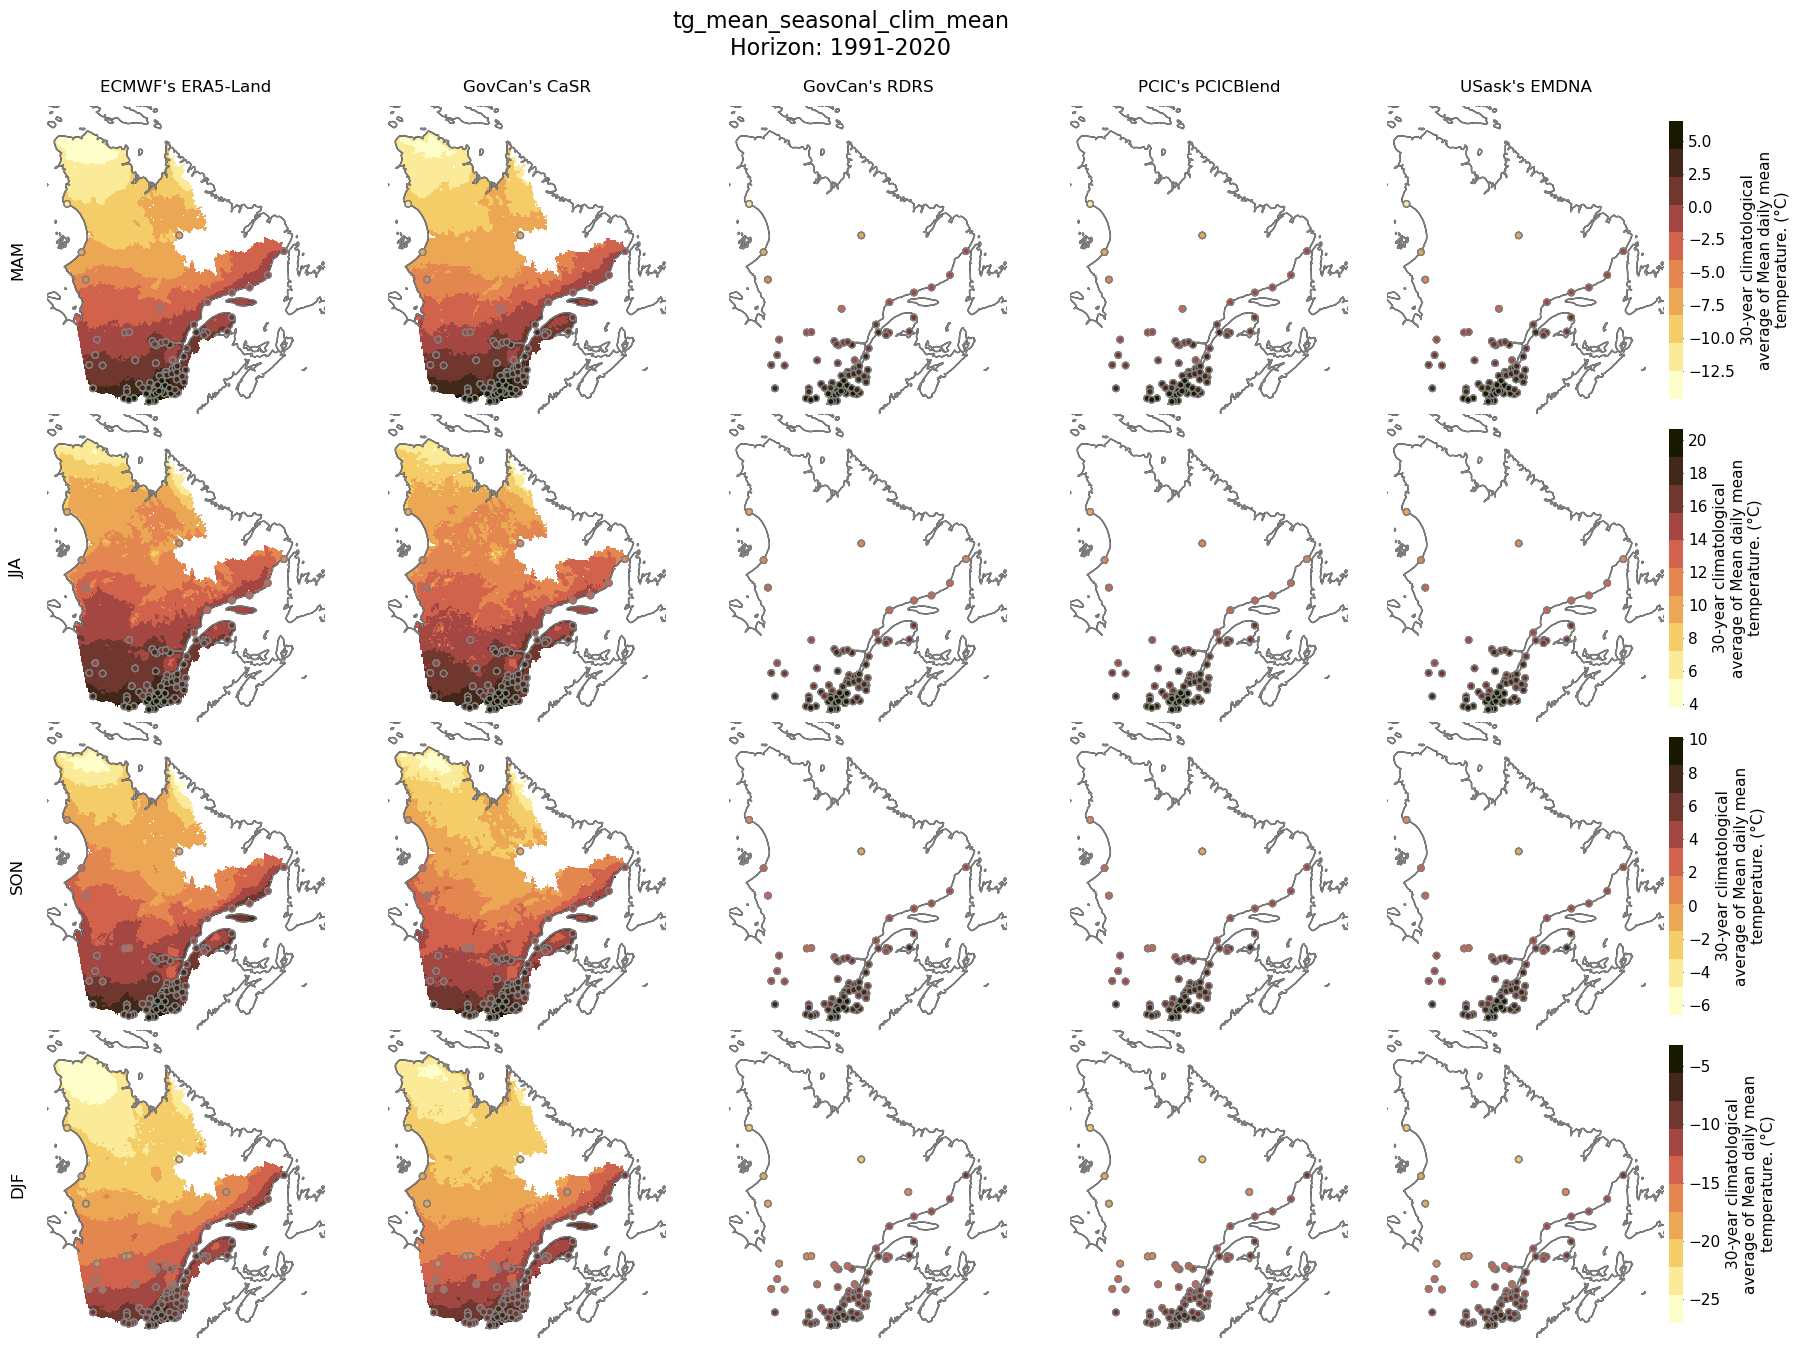

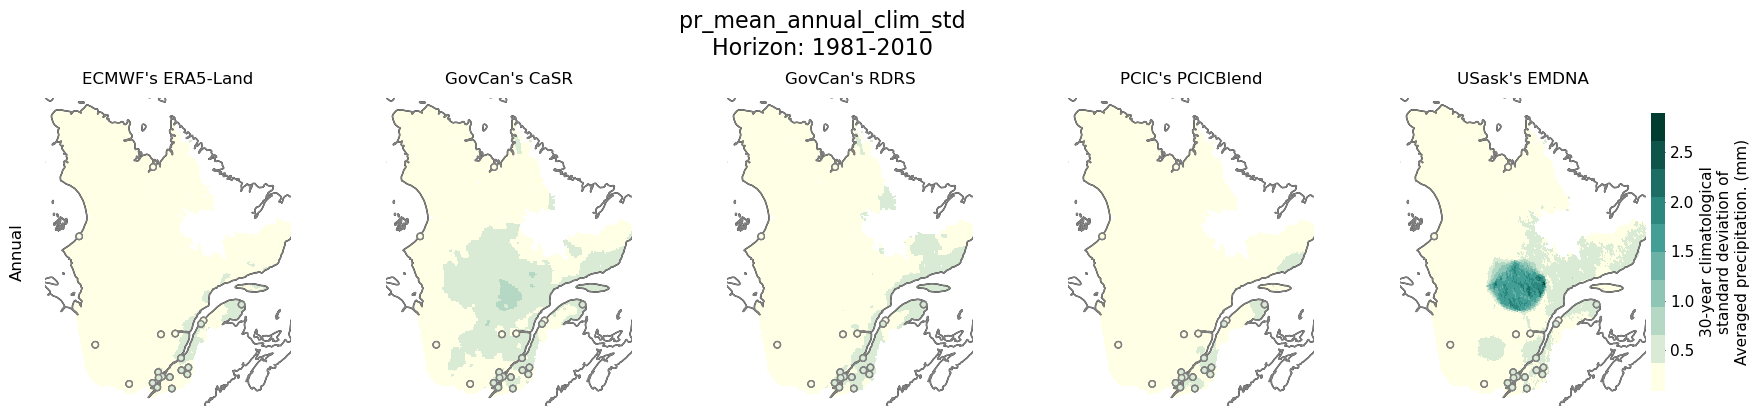

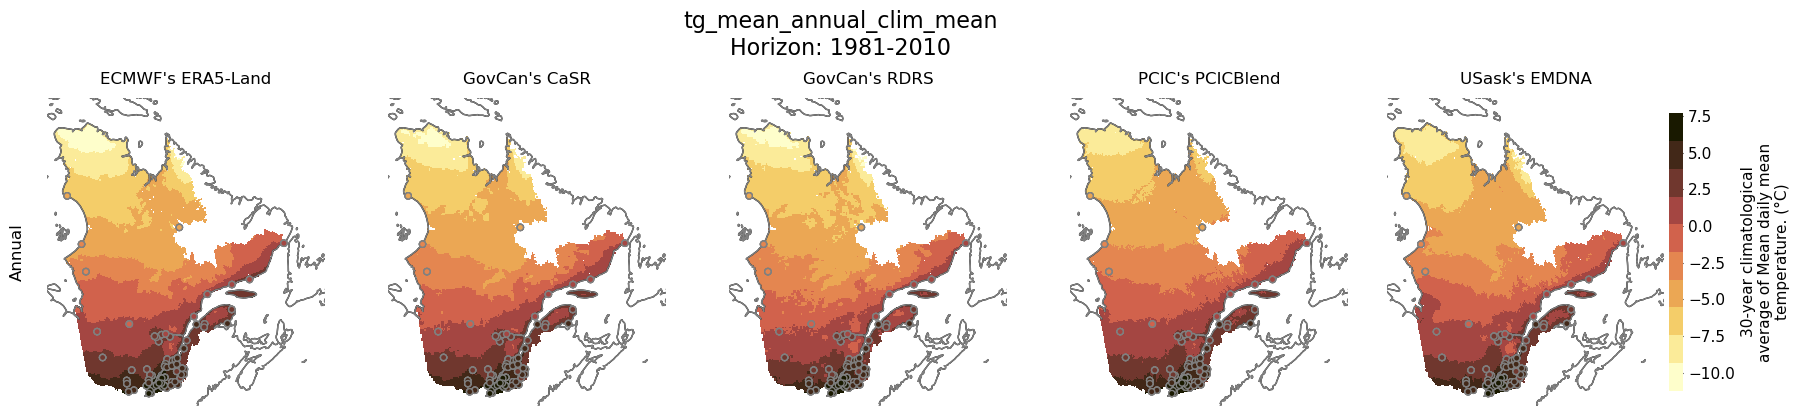

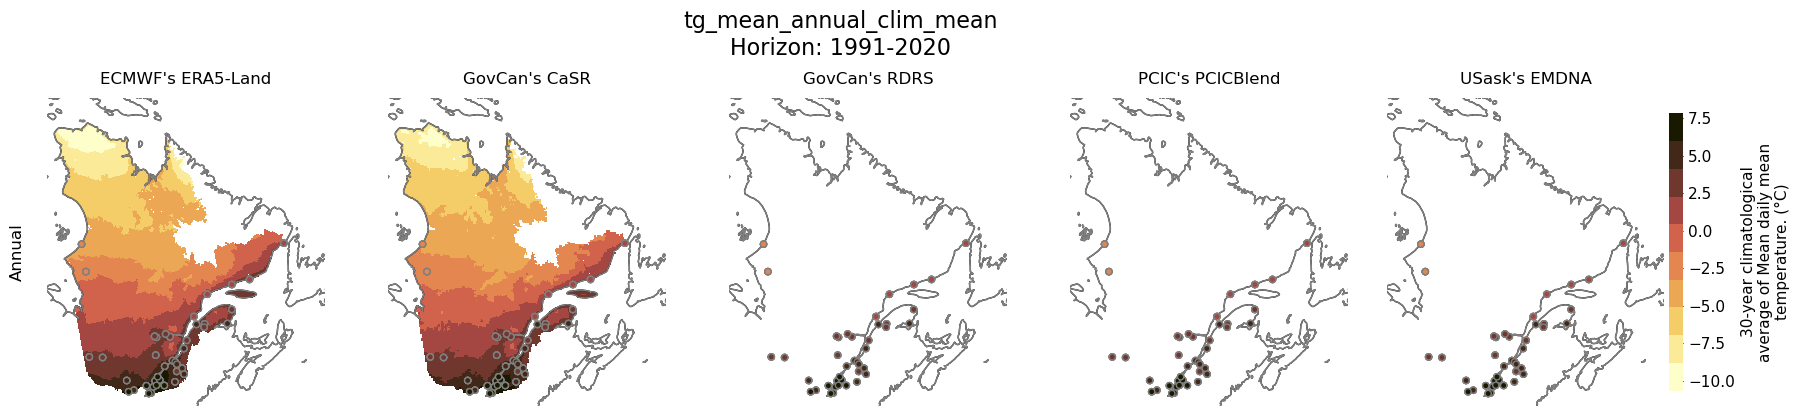

In [13]:
from figanos.matplotlib.utils import create_cmap
cmap = create_cmap("prec")

def get_valid_rec_slice(ds, var, season, horizon):
    if (
        var in ds and
        "season" in ds[var].dims and season in ds[var].season.values and
        "horizon" in ds[var].dims and horizon in ds[var].horizon.values
    ):
        return ds[var].sel(horizon=horizon, season=season).compute()
    return None

def get_global_range(obs_slice, dts_rec, valid_rec_ids, clim_var, season, horizon):
    vmin = obs_slice.min().values.item()
    vmax = obs_slice.max().values.item()
    for rec_id in valid_rec_ids:
        rec_slice = get_valid_rec_slice(dts_rec[rec_id], clim_var, season, horizon)
        if rec_slice is not None:
            vmin = min(vmin, rec_slice.min().values.item())
            vmax = max(vmax, rec_slice.max().values.item())
    return vmin, vmax

def annotate_season(ax, season_label):
    ax.annotate(
        season_label,
        xy=(-0.08, 0.5),
        xycoords='axes fraction',
        ha='right',
        va='center',
        fontsize=12,
        rotation=90
    )

def set_ax_title(ax, ds_meta):
    inst = ds_meta.attrs.get("cat:institution", "") if ds_meta else ""
    src = ds_meta.attrs.get("cat:source", "") if ds_meta else ""
    ax.set_title(f"{inst}'s {src}", fontsize=12)

# === MAIN LOOP ===
pcat_df_clim = pcat_df[pcat_df["processing_level"] == "climatology"]
variable_groups = pcat_df_clim["variable"].unique()
variables = set(item for group in variable_groups for item in group)

for clim_var in variables:
    print(f"Processing variable: {clim_var}")

    dt_obs = pcat.search(processing_level="climatology", variable=clim_var, source="AHCCD").to_dataset()
    dts_rec = pcat.search(processing_level="climatology", variable=clim_var, type="reconstruction").to_dataset_dict()

    if "horizon" not in dt_obs[clim_var].dims:
        continue

    for horizon in dt_obs.horizon.values:
        # Add fake season=annual if missing
        if "season" not in dt_obs[clim_var].dims:
            print(f"\tDetected annual data for {clim_var} — Horizon: {horizon}")
            dt_obs[clim_var] = dt_obs[clim_var].expand_dims(season=["Annual"])
            for rec_id in dts_rec:
                if clim_var in dts_rec[rec_id] and "season" not in dts_rec[rec_id][clim_var].dims:
                    dts_rec[rec_id][clim_var] = dts_rec[rec_id][clim_var].expand_dims(season=["Annual"])

        print(f"\tHorizon: {horizon}")
        obs_var = dt_obs[clim_var].sel(horizon=horizon)
        obs_var = obs_var.expand_dims(rec_ds=sorted(list(dts_rec.keys())))
        mask_nan = obs_var.isnull().compute()
        obs_valid = obs_var.where(~mask_nan, drop=True)

        n_seasons = len(obs_var.season)
        all_rec_ids = sorted(list(dts_rec.keys()))
        valid_rec_ids = [rid for rid in all_rec_ids if get_valid_rec_slice(dts_rec[rid], clim_var, obs_var.season[0].item(), horizon) is not None]
        n_models = len(all_rec_ids)

        import matplotlib.gridspec as gridspec

        fig = plt.figure(
            figsize=(4.2 * n_models + 1.0, 4.0 * n_seasons),
            constrained_layout=False
        )

        gs = gridspec.GridSpec(
            nrows=n_seasons,
            ncols=n_models,
            figure=fig,
            wspace=0.0,
            hspace=0.0
        )

        axs = np.empty((n_seasons, n_models), dtype=object)
        for i in range(n_seasons):
            for j in range(n_models):
                axs[i, j] = fig.add_subplot(gs[i, j], projection=ccrs.LambertConformal())

        for i, season in enumerate(obs_var.season.values):
            season_label = str(season)
            obs_slice = obs_var.sel(season=season)

            vmin, vmax = get_global_range(obs_slice, dts_rec, valid_rec_ids, clim_var, season, horizon)
            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            levels = np.linspace(vmin, vmax, 11)

            for j, rec_id in enumerate(all_rec_ids):
                ax = axs[i, j]
                ax.coastlines()

                lat_vals = obs_var.lat.values
                lon_vals = obs_var.lon.values
                extent = [lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()]
                ax.set_extent(extent, crs=ccrs.PlateCarree())
                is_final_column = (j == n_models - 1)

                rec_slice = get_valid_rec_slice(dts_rec.get(rec_id, {}), clim_var, season, horizon)
                if rec_slice is not None:
                    fg.gridmap(
                        rec_slice,
                        ax=ax,
                        transform=ccrs.PlateCarree() if "lat" in rec_slice.dims else None,
                        plot_kw={"norm": norm, "add_colorbar": False, "zorder": 1},
                        levels=levels,
                        frame=False,
                        show_time=False
                    )

                fg.scattermap(
                    obs_valid.sel(season=season).dropna(dim="station"),
                    ax=ax,
                    plot_kw={
                        "norm": norm,
                        "add_colorbar": is_final_column,
                        "cbar_kwargs": {
                            "shrink": 0.9
                        },
                        "zorder": 3,
                        "edgecolor": "grey",
                        "s": 20,
                        "linewidth": 0.1,
                    },
                    levels=levels,
                    show_time=False,
                    features={"coastline": {"edgecolor": "gray"}},
                    frame=False
                )

                if i == 0:
                    set_ax_title(ax, dts_rec.get(rec_id))
                else:
                    ax.set_title("")
                if j == 0:
                    annotate_season(ax, season_label)

        # Adjust suptitle position dynamically
        suptitle_y = 0.94 if n_seasons > 1 else 1.1
        fig.suptitle(f"{clim_var}\nHorizon: {horizon}", fontsize=16, y=suptitle_y)


## EMDNA Blob timeseries

In [4]:
ds_EMDNA_clim = pcat.search(processing_level="climatology", source="EMDNA", frequency="yr").to_dataset()
ds_EMDNA_clim

<xarray.Dataset> Size: 960kB
Dimensions:                   (horizon: 1, lat: 176, lon: 227)
Coordinates:
  * horizon                   (horizon) <U9 36B '1981-2010'
  * lat                       (lat) float32 704B 45.05 45.15 ... 62.45 62.55
  * lon                       (lon) float32 908B -79.65 -79.55 ... -57.15 -57.05
Data variables:
    pr_mean_annual_clim_mean  (horizon, lat, lon) float64 320kB dask.array<chunksize=(1, 176, 227), meta=np.ndarray>
    pr_mean_annual_clim_std   (horizon, lat, lon) float64 320kB dask.array<chunksize=(1, 176, 227), meta=np.ndarray>
    tg_mean_annual_clim_mean  (horizon, lat, lon) float32 160kB dask.array<chunksize=(1, 176, 227), meta=np.ndarray>
    tg_mean_annual_clim_std   (horizon, lat, lon) float32 160kB dask.array<chunksize=(1, 176, 227), meta=np.ndarray>
Attributes: (12/37)
    crs:                     EPSG:4326
    domain:                  NAM
    frequency:               day
    funding:                 Global Water Futures (GWF)
    history:                 [2025-07-02 16:04:48] shape spatial subsetting w...
    institution:             USask
    ...                      ...
    cat:domain:              Quebec
    cat:date_start:          1980-01-01 00:00:00
    cat:date_end:            2018-01-01 00:00:00
    cat:version:             v10
    cat:_data_format_:       zarr
    cat:path:                /tank/jlavoie/abuyalo/obsflow/climatology/USask_...

In [5]:
ds_EMDNA_ind = pcat.search(processing_level="indicators", source="EMDNA", frequency="yr").to_dataset()
ds_EMDNA_ind

<xarray.Dataset> Size: 19MB
Dimensions:         (lat: 176, lon: 227, time: 39)
Coordinates:
  * lat             (lat) float32 704B 45.05 45.15 45.25 ... 62.35 62.45 62.55
  * lon             (lon) float32 908B -79.65 -79.55 -79.45 ... -57.15 -57.05
  * time            (time) datetime64[ns] 312B 1980-01-01 ... 2018-01-01
Data variables:
    pr_mean_annual  (time, lat, lon) float64 12MB dask.array<chunksize=(39, 176, 227), meta=np.ndarray>
    tg_mean_annual  (time, lat, lon) float32 6MB dask.array<chunksize=(39, 176, 227), meta=np.ndarray>
Attributes: (12/37)
    crs:                     EPSG:4326
    domain:                  NAM
    frequency:               day
    funding:                 Global Water Futures (GWF)
    history:                 [2025-07-02 16:04:48] shape spatial subsetting w...
    institution:             USask
    ...                      ...
    cat:domain:              Quebec
    cat:date_start:          1980-01-01 00:00:00
    cat:date_end:            2018-01-01 00:00:00
    cat:version:             v10
    cat:_data_format_:       zarr
    cat:path:                /tank/jlavoie/abuyalo/obsflow/indicators/USask_E...

In [6]:
horizon = ds_EMDNA_clim.horizon.values
print(horizon)
pr_clim = ds_EMDNA_clim.isel(horizon=0).pr_mean_annual_clim_std


pr_ind = ds_EMDNA_ind.sel(time=slice("1981","2010")).pr_mean_annual

lat_on = 51.6
lon_on = -70.4
pr_ind_on = pr_ind.sel(lat=lat_on,lon=lon_on,method="nearest")

lat_off = 49.6
lon_off = -69
pr_ind_off = pr_ind.sel(lat=lat_off,lon=lon_off,method="nearest")


['1981-2010']


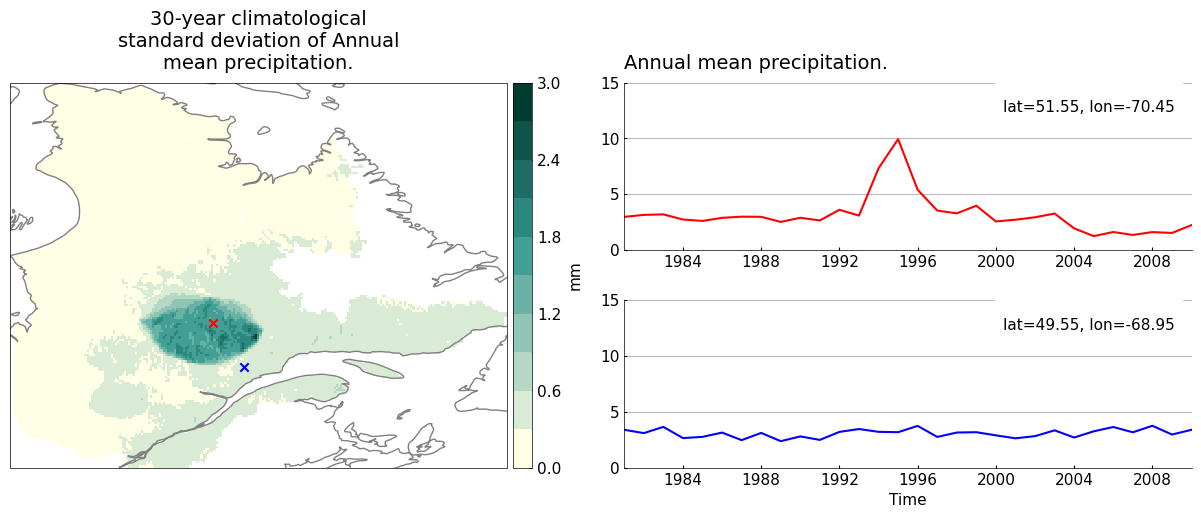

In [7]:
fig = plt.figure(figsize=(25, 5))  # Slightly wider, not overly tall
outer = gridspec.GridSpec(1, 2, width_ratios=[2.3, 1], wspace=0.07)

# === Left: Gridmap (takes full height) ===
ax_map = fig.add_subplot(outer[0], projection=ccrs.PlateCarree())
fg.gridmap(
    ds_EMDNA_clim.pr_mean_annual_clim_std.isel(horizon=0),
    transform=ccrs.PlateCarree(),
    levels=10,
    frame=True,
    show_time=False,
    features={"coastline": {"edgecolor": "gray"}},
    ax=ax_map,
    plot_kw={
        "cbar_kwargs": {
            "fraction": 0.035,  # narrower
            "pad": 0.005,          # tighter to map
            "label": ds_EMDNA_clim.pr_mean_annual_clim_std.isel(horizon=0).attrs["units"]
        }
    }
)
ax_map.scatter(lon_on, lat_on, transform=ccrs.PlateCarree(), color="red", marker="x", zorder=4)
ax_map.scatter(lon_off, lat_off, transform=ccrs.PlateCarree(), color="blue", marker="x", zorder=4)


# === Right: Two stacked timeseries ===
right = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1], height_ratios=[1, 1], hspace=0.3)

ylim = [0, 15]

# Top timeseries
ax_ts_top = fig.add_subplot(right[0])
fg.timeseries(pr_ind_on, ax=ax_ts_top, plot_kw={"color": "red"},show_lat_lon="upper right")
ax_ts_top.set_ylim(ylim)
ax_ts_top.set_xlabel("")  # suppress x-label on top plot
ax_ts_top.set_ylabel("")

# Bottom timeseries
ax_ts_bottom = fig.add_subplot(right[1])
fg.timeseries(pr_ind_off, ax=ax_ts_bottom, plot_kw={"color": "blue"},show_lat_lon="upper right")
ax_ts_bottom.set_ylim(ylim)
ax_ts_bottom.set_title("", loc="left", fontsize=11)
ax_ts_bottom.set_ylabel("")

plt.show()
